## Dateset: https://www.kaggle.com/c/rossmann-store-sales/kernels

## Libraries: 

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm import tqdm
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

## Data Preparation 

In [3]:
df=pd.read_csv('train.csv',parse_dates=['Date'])

In [4]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df.shape

(1017209, 9)

### Target Variable 

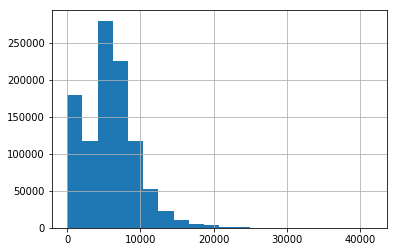

In [6]:
df['Sales'].hist(bins=20)

In [7]:
df['Sales'].describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

### Store Vs Sales

In [8]:
df['Store'].nunique()

1115

In [9]:
max(df['Sales'])

41551

In [10]:
df[df['Sales']>40000]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
44393,909,1,2015-06-22,41551,1721,1,0,0,0


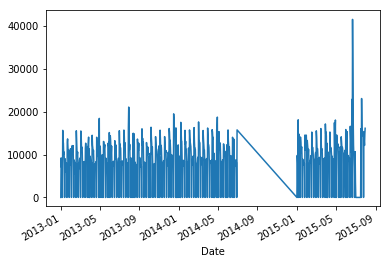

In [11]:
df[(df['Store']==909)].groupby('Date').Sales.sum().plot(kind='line')

In [12]:
(max(df['Date'])-min(df['Date']))

Timedelta('941 days 00:00:00')

In [13]:
(df['Store'].value_counts() < 941).sum()

180

In [14]:
New_Sales = pd.DataFrame()

##### Removing outliers 

In [15]:
for a in tqdm(df.Store.drop_duplicates().tolist()):
    store_1 = df[df['Store']==a]
    ##IQR=df['Sales'][df['Store']==store].quantile(.75)-df['Sales'][df['Store']==store].quantile(.25)
    store_1['new_sales']=np.where(store_1['Sales']>(3.25*store_1['Sales'].std()+store_1['Sales'].mean()),
                            (3.25*store_1['Sales'].std()+store_1['Sales'].mean()),store_1['Sales'])
    New_Sales = New_Sales.append(store_1).reset_index(drop = True)

100%|██████████| 1115/1115 [02:33<00:00,  4.23it/s]


In [16]:
New_Sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,new_sales
0,1,5,2015-07-31,5263,555,1,1,0,1,5263.0
1,1,4,2015-07-30,5020,546,1,1,0,1,5020.0
2,1,3,2015-07-29,4782,523,1,1,0,1,4782.0
3,1,2,2015-07-28,5011,560,1,1,0,1,5011.0
4,1,1,2015-07-27,6102,612,1,1,0,1,6102.0


In [17]:
New_Sales['logsales']=np.log(New_Sales['new_sales']+1)

In [18]:
New_Sales['Flag']=1

In [19]:
#### Appending test data 

In [20]:
test=pd.read_csv('test.csv',parse_dates=['Date'])

In [21]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [22]:
test['Flag']=0

In [23]:
df=New_Sales.append(test)

In [24]:
df.shape

(1058297, 13)

In [25]:
df.head()

,Customers,Date,DayOfWeek,Flag,Id,Open,Promo,Sales,SchoolHoliday,StateHoliday,Store,logsales,new_sales
0,555.0,2015-07-31,5,1,NaN,1.0,1,5263.0,1,0,1,8.568646,5263.0
1,546.0,2015-07-30,4,1,NaN,1.0,1,5020.0,1,0,1,8.521384,5020.0
2,523.0,2015-07-29,3,1,NaN,1.0,1,4782.0,1,0,1,8.472823,4782.0
3,560.0,2015-07-28,2,1,NaN,1.0,1,5011.0,1,0,1,8.519590,5011.0
4,612.0,2015-07-27,1,1,NaN,1.0,1,6102.0,1,0,1,8.716536,6102.0


In [26]:
store=pd.read_csv('store.csv')

In [27]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [28]:
df=pd.merge(df,store,left_on='Store',right_on='Store',how = 'left')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 1058296
Data columns (total 22 columns):
Customers                    1017209 non-null float64
Date                         1058297 non-null datetime64[ns]
DayOfWeek                    1058297 non-null int64
Flag                         1058297 non-null int64
Id                           41088 non-null float64
Open                         1058286 non-null float64
Promo                        1058297 non-null int64
Sales                        1017209 non-null float64
SchoolHoliday                1058297 non-null int64
StateHoliday                 1058297 non-null object
Store                        1058297 non-null int64
logsales                     1017209 non-null float64
new_sales                    1017209 non-null float64
StoreType                    1058297 non-null object
Assortment                   1058297 non-null object
CompetitionDistance          1055559 non-null float64
CompetitionOpenSinceMonth    71

In [30]:
df.nunique()

Customers                     4086
Date                           990
DayOfWeek                        7
Flag                             2
Id                           41088
Open                             2
Promo                            2
Sales                        21734
SchoolHoliday                    2
StateHoliday                     5
Store                         1115
logsales                     21992
new_sales                    21992
StoreType                        4
Assortment                       3
CompetitionDistance            654
CompetitionOpenSinceMonth       12
CompetitionOpenSinceYear        23
Promo2                           2
Promo2SinceWeek                 24
Promo2SinceYear                  7
PromoInterval                    3
dtype: int64

## EDA

In [31]:
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df['Day'] = df.Date.dt.day
df['DayOfWeek'] = df.Date.dt.dayofweek
df['WeekOfYear'] = df.Date.dt.weekofyear

In [32]:
df['MonthYear']=df['Date'].dt.to_period('M')

#### Customer Vs Sales 

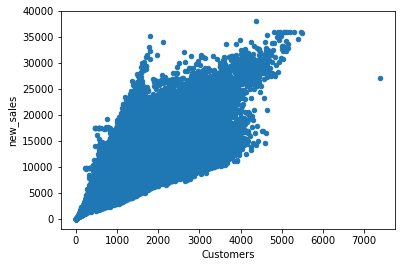

In [33]:
df.plot(kind='scatter',x='Customers',y='new_sales')

In [34]:
df['logcustomers']=np.log(df['Customers']+1)

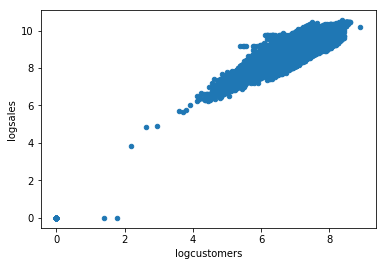

In [35]:
df.plot(kind='scatter',x='logcustomers',y='logsales')

In [36]:
df1=df.groupby('Store')['logsales','logcustomers'].mean().reset_index().rename({'logsales' : 'Avglogsales', 'logcustomers' : 'Avglogcustomers'}, axis='columns')

In [37]:
df=pd.merge(df, df1 ,left_on='Store' ,right_on='Store' ,how='left')

In [38]:
sc=['new_sales','logsales','Avglogsales','Avglogcustomers']

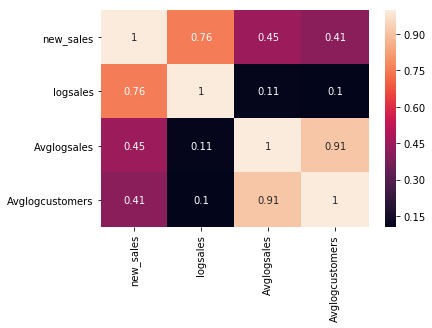

In [39]:
sns.heatmap(df[sc].corr(),annot=True)

### StoreType Vs Sales 

In [40]:
df['StoreType'].value_counts()

a    573755
d    327024
c    141112
b     16406
Name: StoreType, dtype: int64

In [41]:
df.groupby('StoreType').new_sales.mean()

StoreType
a     5736.994637
b    10056.200900
c     5722.242788
d     5640.952862
Name: new_sales, dtype: float64

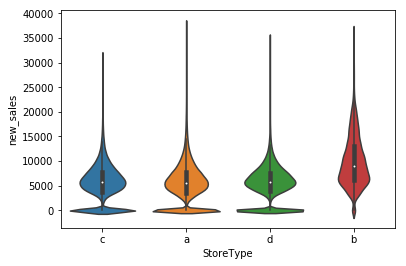

In [42]:
sns.violinplot(y='new_sales', x='StoreType', data=df)

### Assortment Vs Sales 

In [43]:
df['Assortment'].value_counts()

a    557749
c    491822
b      8726
Name: Assortment, dtype: int64

In [44]:
df.groupby('Assortment').new_sales.mean()

Assortment
a    5479.792608
b    8551.557169
c    6057.671946
Name: new_sales, dtype: float64

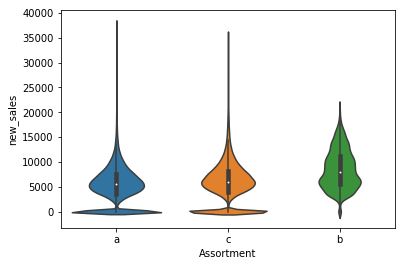

In [45]:
sns.violinplot(y='new_sales', x='Assortment', data=df)

### Promo1 Vs Sales

In [46]:
df['Promo'].value_counts()

0    653953
1    404344
Name: Promo, dtype: int64

In [47]:
df.groupby('Promo').new_sales.mean()

Promo
0    4405.520716
1    7989.031909
Name: new_sales, dtype: float64

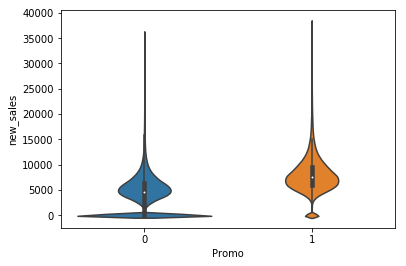

In [48]:
sns.violinplot(y='new_sales', x='Promo', data=df)

### Competition Vs Sales

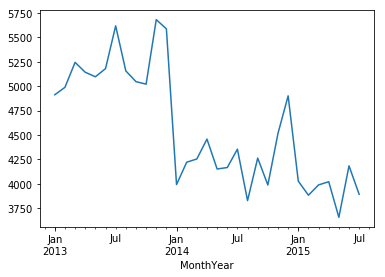

In [49]:
df[(df['Store']==6)].groupby('MonthYear').new_sales.mean().plot(kind='line')

In [50]:
df[(df['Store']==6)][['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','CompetitionDistance']].head()

,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionDistance
4710,12.0,2013.0,310.0
4711,12.0,2013.0,310.0
4712,12.0,2013.0,310.0
4713,12.0,2013.0,310.0
4714,12.0,2013.0,310.0


In [51]:
df['CompetitionOpenSinceMonth'].isnull().sum()

338564

In [52]:
df['CompetitionDistance'].isnull().sum()

2738

In [53]:
df['CompFlag']=np.where((df['CompetitionOpenSinceMonth'].isnull()) & (df['CompetitionDistance'].isnull()) ,0,1)

In [54]:
df['CompFlag'].value_counts()

1    1055559
0       2738
Name: CompFlag, dtype: int64

In [55]:
df['CompetitionOpenSinceMonth'].fillna(df['CompetitionOpenSinceMonth'].median(),inplace = True)

In [56]:
df['CompetitionOpenSinceYear'].fillna(df['CompetitionOpenSinceYear'].median(),inplace = True)

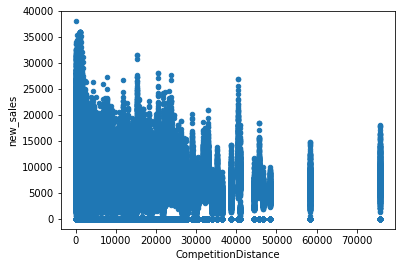

In [57]:
df[df['CompetitionDistance'] > 0].plot(kind='scatter',x='CompetitionDistance',y='new_sales')

In [58]:
df['compdistflag'] = np.where(df['CompetitionDistance']>20000,0,1)

In [59]:
df['compstrt']= np.where((df['CompetitionOpenSinceYear'] < df['Year'])
                         | ((df['CompetitionOpenSinceYear'] == df['Year']) & 
                         (df['CompetitionOpenSinceMonth']<= df['Month'])) ,1,0)

In [60]:
df['CompFlag'] = df['compstrt'] * df['compdistflag'] * df['CompFlag'] 

In [61]:
df.groupby('CompFlag').new_sales.mean()

CompFlag
0    5946.382966
1    5746.117830
Name: new_sales, dtype: float64

In [62]:
df['CompDuration'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)

### Promo2 Vs Sales

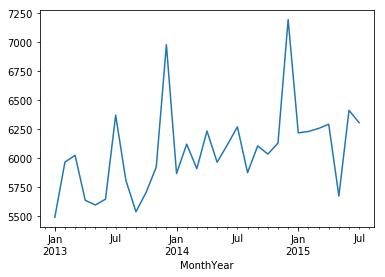

In [63]:
df[(df['Store']==1060)].groupby('MonthYear').new_sales.mean().plot(kind='line')

In [64]:
df.groupby('PromoInterval').Store.count()

PromoInterval
Feb,May,Aug,Nov     124308
Jan,Apr,Jul,Oct     306898
Mar,Jun,Sept,Dec    101828
Name: Store, dtype: int64

In [65]:
df.groupby('PromoInterval').new_sales.mean()

PromoInterval
Feb,May,Aug,Nov     5308.695899
Jan,Apr,Jul,Oct     5561.280015
Mar,Jun,Sept,Dec    5142.693037
Name: new_sales, dtype: float64

In [66]:
new = df["PromoInterval"].str.split(",", n = 3, expand = True) 

In [67]:
df['m1']=new[0]

In [68]:
df['m2']=new[1]

In [69]:
df['m3']=new[2]

In [70]:
df['m4']=new[3]

In [71]:
monthmap ={1 :'Jan', 
           2: 'Feb',
           3: 'Mar',
           4: 'Apr',
           5: 'May',
           6: 'Jun',
           7: 'Jul',
           8: 'Aug',
           9:'Sept',
           10:'Oct',
           11:'Nov',
           12:'Dec' }

In [72]:
df["MonthName"]=df["Month"].map(monthmap)

In [73]:
df['PromoMonth']=np.where((df['MonthName']==df['m1']) | (df['MonthName']==df['m2']) 
                      | (df['MonthName']==df['m3']) | (df['MonthName']==df['m4']), 1 , 0)

In [74]:
df['Promo2SinceWeek'].fillna(0,inplace = True)

In [75]:
df['Promo2SinceYear'].fillna(0,inplace = True)

In [76]:
df['Promostrt']= np.where((df['Promo2SinceYear'] < df['Year'])
                         | ((df['Promo2SinceYear'] == df['Year']) & 
                         (df['Promo2SinceWeek']<= df['WeekOfYear'])) ,1,0)

In [77]:
df['Promo2Flag']=df['PromoMonth'] *  df['Promostrt']

In [78]:
df.groupby('Promo2Flag').new_sales.mean()

Promo2Flag
0    5842.221726
1    5376.729663
Name: new_sales, dtype: float64

In [79]:
df['PromoDuration'] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek) / 4.0

In [80]:
df.groupby(['Promo','Promo2Flag','CompFlag']).Sales.mean()

Promo  Promo2Flag  CompFlag
0      0           0           4527.151863
                   1           4462.014757
       1           0           4211.739713
                   1           4015.457740
1      0           0           8339.251013
                   1           8035.178357
       1           0           8126.193442
                   1           7458.166718
Name: Sales, dtype: float64

#### Store Correlation 

In [81]:
store_piv= pd.pivot_table(df,values='Sales', index='Date', columns=['Store'],aggfunc='sum')

In [82]:
start_store = 1
end_store   = 5

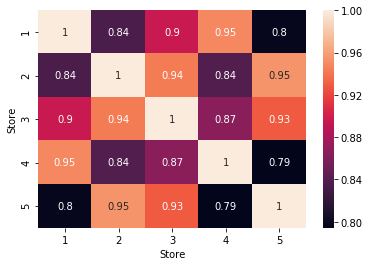

In [83]:
sns.heatmap(store_piv[list(range(start_store, end_store+1))].corr(),annot=True)

In [84]:
mapping = {'0':0 , 'a' : 1, 'b' : 2, 'c' : 3, 'd':4}

In [85]:
df['Assortment'].replace(mapping,inplace=True)

In [86]:
df['StateHoliday'].replace(mapping,inplace=True)

In [87]:
df['StoreType'].replace(mapping,inplace=True)

## Time Series Analysis

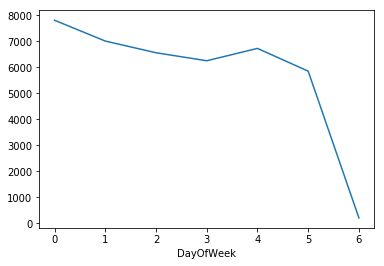

In [88]:
df.groupby('DayOfWeek').new_sales.mean().plot(kind='line')

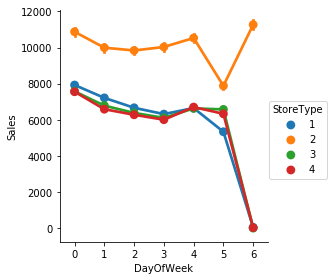

In [89]:
sns.factorplot(data = df, x = 'DayOfWeek', y = 'Sales', hue = 'StoreType') 

In [90]:
store_1 = df[['Sales', 'Date']][(df['Store']==1)&(df['Open']==1) & (df['Flag']==1)].reset_index(drop = True).sort_values('Date')
store_1.set_index('Date', inplace = True)

In [91]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(store_1, freq = 7)

In [92]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

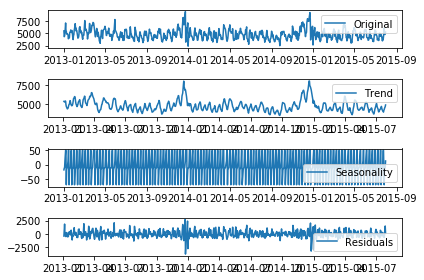

In [93]:
plt.subplot(411)
plt.plot(store_1, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Missing Imputation 

In [94]:
df.isna().sum()

Customers                      41088
Date                               0
DayOfWeek                          0
Flag                               0
Id                           1017209
Open                              11
Promo                              0
Sales                          41088
SchoolHoliday                      0
StateHoliday                       0
Store                              0
logsales                       41088
new_sales                      41088
StoreType                          0
Assortment                         0
CompetitionDistance             2738
CompetitionOpenSinceMonth          0
CompetitionOpenSinceYear           0
Promo2                             0
Promo2SinceWeek                    0
Promo2SinceYear                    0
PromoInterval                 525263
Year                               0
Month                              0
Day                                0
WeekOfYear                         0
MonthYear                          0
l

In [95]:
df['Promo'].fillna(0,inplace=True)                              

In [96]:
df['CompetitionDistance'].fillna(0,inplace=True)                              

## Models  

In [173]:
train = df[(df['Flag']== 1) & (df['Date']<'2015-05-01')].drop(['Id','Date','Customers','Sales','Flag','new_sales',
                                  'm1','m2','m3','m4','PromoInterval','MonthName','PromoMonth',
                                  'Promostrt','compdistflag','compstrt','logcustomers','MonthYear'], 1)

In [136]:
validation = df[(df['Flag']== 1) & (df['Date']>'2015-05-01')].drop(['Id','Date','Customers','Sales','Flag','new_sales',
                                  'm1','m2','m3','m4','PromoInterval','MonthName','PromoMonth',
                                  'Promostrt','compdistflag','compstrt','logcustomers','MonthYear'], 1)

In [176]:
test = df[df['Flag']== 0].drop(['Date','Customers','Sales','Flag','new_sales',
                                  'm1','m2','m3','m4','PromoInterval','MonthName','PromoMonth',
                                  'Promostrt','compdistflag','compstrt','logcustomers','MonthYear'], 1)

In [138]:
train.shape , validation.shape, test.shape 

((914629, 25), (101465, 25), (41088, 26))

In [124]:
predictors = [x for x in train.columns if x not in ['logsales']]

In [182]:
trainlist = []
testlist = []
dp_list = np.arange(5, 15)

In [183]:
train1 = pd.DataFrame(train)

In [184]:
test1 = pd.DataFrame(test)

In [186]:
for depth in dp_list:   
    tree = XGBRegressor(max_depth=depth)
    tree.fit(train[predictors], train['logsales'])
    prediction = tree.predict(validation[predictors])
    trainpred = tree.predict(train[predictors])
    train_err = mean_squared_error(train['logsales'], trainpred)
    test_err = mean_squared_error(validation['logsales'], prediction)
    trainlist.append(train_err)
    testlist.append(test_err)
    
performance = pd.DataFrame({'max_depth':dp_list,'Train_err':trainlist,'Test_err':testlist})

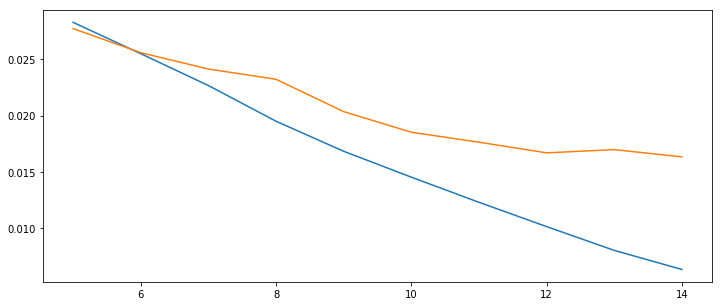

In [189]:
fig, (ax1) = plt.subplots(figsize = (12, 5))
x_axis = dp_list
ax1.plot(x_axis, performance['Train_err'], label='Train')
ax1.plot(x_axis, performance['Test_err'], label='Test')

In [195]:
def modelfit(alg, dtrain, predictors, cv_folds=5, early_stopping_rounds=50):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['logsales'].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, 
                      metrics='rmse', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['logsales'],eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    print (mean_squared_error(dtrain['logsales'].values, dtrain_predictions))
                    
    fig, ax = plt.subplots(1, 1, figsize=(8, 16))
    xgb.plot_importance(alg, max_num_features=50, height=0.5, ax=ax)
    

0.010785752091612175


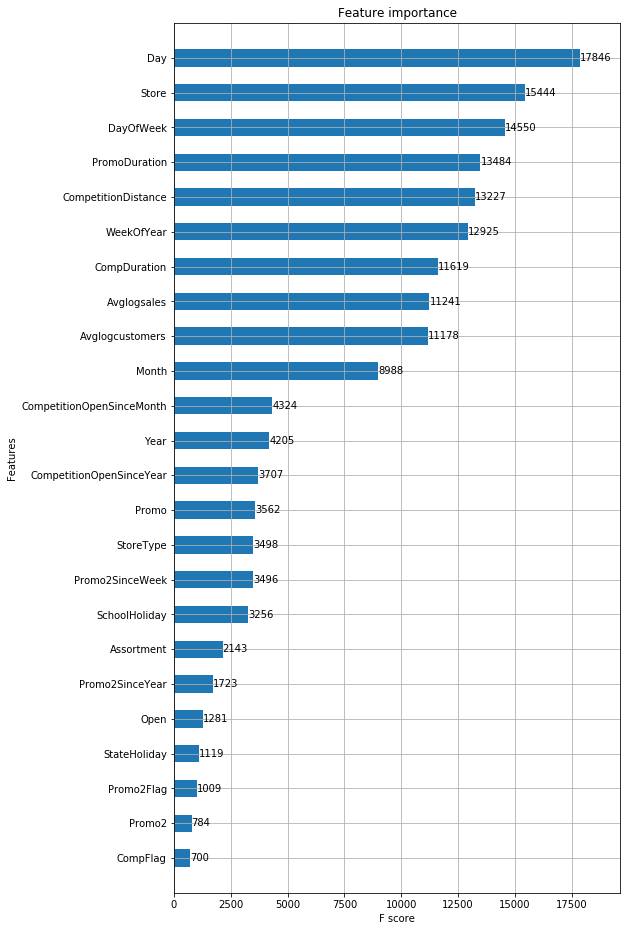

In [196]:
xgb1 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=.8,
       colsample_bytree=.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0.0001, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=.8)
modelfit(xgb1, train, predictors)